<a href="https://colab.research.google.com/github/JonMcEntee/hm-fashion-recommendations/blob/main/H%26M_Fashion_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# H&M Fashion Recommendations

This notebook details my approach to Kaggle's [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview) competition, focused on predicting customers' next fashion purchases. With vast product selections becoming standard in retail, delivering precisely tailored suggestions is key to enhancing shopping experiences and brand loyalty in modern fashion commerce.

In [16]:
articles = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [17]:
# Trick to reduce size in memory
customer_id_to_index_dict = dict(zip(customers["customer_id"], customers.index))
# customer_index_to_id_dict = dict(zip(customers.index, customers["customer_id"]))

transactions["customer_id"] = transactions["customer_id"].map(customer_id_to_index_dict)
customers["customer_id"] = customers["customer_id"].map(customer_id_to_index_dict)

article_id_to_index_dict = dict(zip(articles["article_id"], customers.index))
# article_index_to_id_dict = dict(zip(customers.index, articles["article_id"]))

transactions["article_id"] = transactions["article_id"].map(article_id_to_index_dict)
articles["article_id"] = articles["article_id"].map(article_id_to_index_dict)

# Exploratory Data Analysis

Lets first examine the data and understand how it is distributed. We will start by looking at what articles are being sold and in what frequency

In [51]:
article_details = pd.merge(transactions,
                           articles[["article_id",
                                     "product_type_name",
                                     "product_group_name"]],
                           how="left", on="article_id")

product_types = article_details.groupby("product_type_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

product_groups = article_details.groupby("product_group_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

del article_details

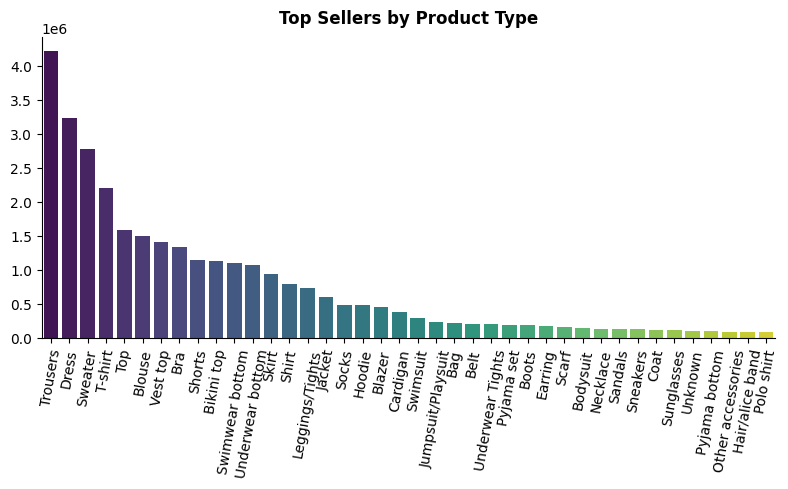

In [79]:
plt.figure(figsize=(8, 5))
g = sns.barplot(product_types.head(40), x = "product_type_name", y = "count", hue="product_type_name", palette='viridis')
g.tick_params(axis='x', labelrotation=80, labelsize=10);
g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Type", fontweight='bold', pad=10)
sns.despine()
plt.tight_layout()

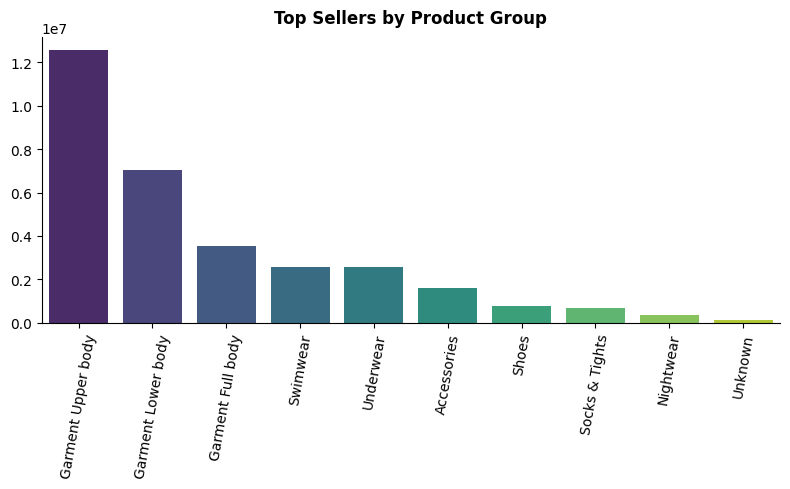

In [80]:
plt.figure(figsize=(8, 5))
g = sns.barplot(product_groups.head(10), x = "product_group_name", y = "count", hue="product_group_name", palette='viridis')
g.tick_params(axis='x', labelrotation=80, labelsize=10);
g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Group", fontweight='bold', pad=10)
sns.despine()
plt.tight_layout()